# Horizon Shading

My attempt to find horizon lines through optimization.
Here's what I do:

* Generate a horizon line that makes "sense"
* Apply its effect on clearsky data
* Find through optimization techniques (Particle Swarm, regular grad. descent)
* Add generated clearsky indices to the clearsky data
* Run PV power simulation before searching the horizonline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import pvlib

pvlib.__version__

'0.7.0'

## Clearsky data and sun angles

Text(0, 0.5, 'Irradiance [W/m²]')

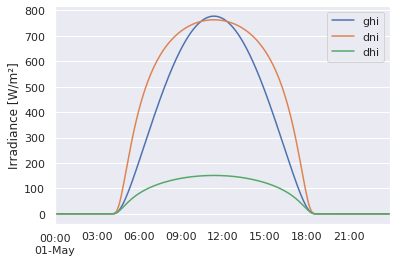

In [2]:
location = pvlib.location.Location(50.1109, 8.6821)
df = location.get_clearsky(pd.date_range("2020-01-01", "2020-12-31", freq="5min"))

df.loc["2020-05-01"].plot()
plt.ylabel("Irradiance [W/m²]")

Text(0, 0.5, 'Sun angles [°]')

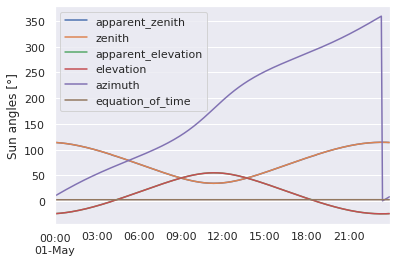

In [3]:
df2 = location.get_solarposition(df.index)

df2.loc["2020-05-01"].plot()
plt.ylabel("Sun angles [°]")

Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)

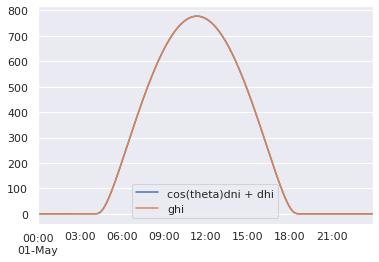

In [4]:
df3 = df.join(df2)
df3["zenith"] = np.radians(df3.zenith)

(np.cos(df3.zenith) * df3.dni + df3.dhi).loc["2020-05-01"].plot(label="cos(theta)dni + dhi")
df3.loc["2020-05-01"].ghi.plot()
plt.legend()

## Horizon line

Text(0.5, 1.0, 'Sun elevation above generated horizon line on 2020-05-01')

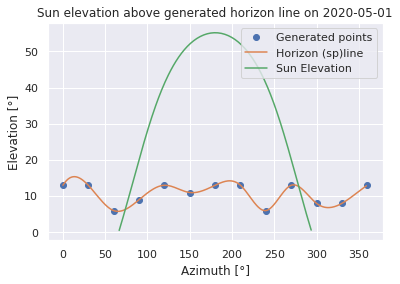

In [5]:
import scipy
from scipy import interpolate

x = np.arange(0, 361, 30)
y = np.random.randint(5,15, len(x)-1)
y = np.append(y, y[0])

tck = interpolate.splrep(x, y, s=0)

azimuth = np.arange(0,360) 

elevation = interpolate.splev(azimuth, tck, der=0)

plt.plot(x,y, 'o', label="Generated points")
plt.plot(azimuth, elevation, label="Horizon (sp)line")


azi = df3[df3.elevation>0].loc["2020-05-01"].azimuth.values
ele = df3[df3.elevation>0].loc["2020-05-01"].elevation.values
plt.plot(azi, ele, label="Sun Elevation")

plt.legend()
plt.xlabel("Azimuth [°]")
plt.ylabel("Elevation [°]")
plt.title("Sun elevation above generated horizon line on 2020-05-01")

## Effect of horizon shading on irradiance

/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dutchman/miniconda3.1/lib/python3.7/_collections_abc.py:841: Matpl

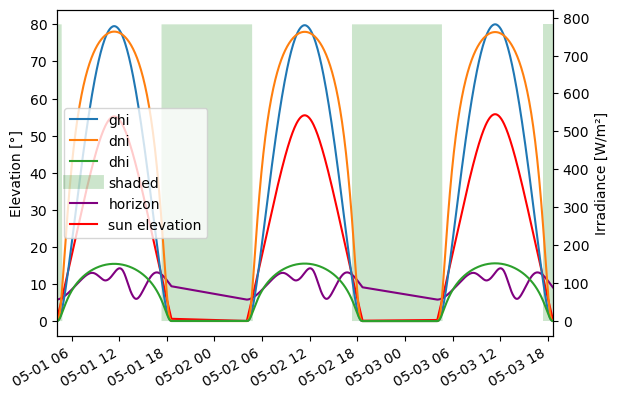

In [6]:
sns.reset_orig()

df3["horizon"] = interpolate.splev(df3.azimuth, tck, der=0)
df3["shaded"] = (df3.elevation < interpolate.splev(df3.azimuth, tck, der=0))

tmp = df3[df3.elevation>0].loc["2020-05-01":"2020-05-03"]


ax = tmp.horizon.plot(color="purple")
tmp.elevation.plot(ax=ax, color="red")
plt.fill_between(tmp.index, 0, 80, facecolor='green', interpolate=True, alpha=.2, where=tmp.shaded)

ax2 = ax.twinx()
tmp.ghi.plot(ax=ax2)
tmp.dni.plot(ax=ax2)
tmp.dhi.plot(ax=ax2)



plt.plot([],[], color="green", alpha=.2, linewidth=10, label="shaded")
plt.plot([], [], color="purple", label="horizon")
plt.plot([], [], color="red", label="sun elevation")

plt.legend()

ax.set_ylabel("Elevation [°]")
ax2.set_ylabel("Irradiance [W/m²]")

sns.set()

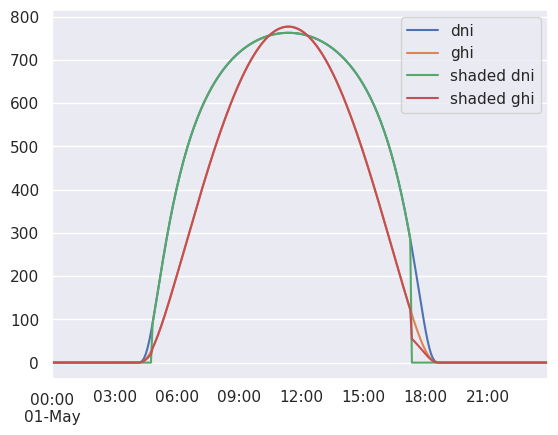

In [7]:
df3["shaded dni"] = df3.dni
df3.loc[df3.shaded, "shaded dni"] = 0

df3["shaded ghi"] = (np.cos(df3.zenith) * df3["shaded dni"] + df3.dhi)

df3.loc["2020-05-01"]["dni"].plot()
df3.loc["2020-05-01"]["ghi"].plot()
df3.loc["2020-05-01"]["shaded dni"].plot()
df3.loc["2020-05-01"]["shaded ghi"].plot()
plt.legend()

In [8]:
def horizon_shading(horizon):
    tmp = df3.copy()
    tmp["horizon"] = interpolate.splev(tmp.azimuth, horizon, der=0)
    tmp["shaded"] = (tmp.elevation < tmp["horizon"])
    tmp["shaded dni"] = df3.dni
    tmp.loc[tmp.shaded, "shaded dni"] = 0

    retval = (np.cos(tmp.zenith) * tmp["shaded dni"] + tmp.dhi)
    return retval

def plot_horizon(horizon):
    tmp = df3.loc["2020-05-01"].copy()
    tmp["horizon"] = interpolate.splev(tmp.azimuth, horizon, der=0)
    tmp = tmp.reset_index().set_index("azimuth")
    return tmp[tmp.elevation>0].horizon

def arr2spl(arr):
    retval = interpolate.splrep(np.arange(0, 361, 30), arr, s=0)
    return retval

## Find horizon through optimization (PSO)

In [10]:
x = np.arange(0, 361, 30)
y = np.random.randint(5,15, len(x)-1)
y = np.append(y, y[0])

hor1 = interpolate.splrep(x, y, s=0)

rmsd = lambda x,y : np.sqrt(((x-y)**2).mean())
rmsd(horizon_shading(hor1), df3["shaded ghi"])

10.30672580922326

In [11]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
ps.__version__

dim = 13

def f(x):
    nofpart, dim = x.shape
    horz = [interpolate.splrep(np.arange(0, 361, 30), x[ix, :], s=0) for ix in range(nofpart)]
    retval = np.array([rmsd(horizon_shading(hor), df3["shaded ghi"]) for hor in horz])
    return retval

# instatiate the optimizer
x_max = 20 * np.ones(dim)
x_min = np.zeros(dim)
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=13, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(f, 10)

2020-02-04 22:40:30,857 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=6.75
2020-02-04 22:40:32,568 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.753265430280227, best pos: [ 6.13347862 13.67533585 13.92977804 11.22541867 12.47487121 10.01877426
 12.87150247 13.26469277  8.02131981 12.4320809  12.93263726  5.13130919
 12.06348823]


In [12]:
pso = lambda nofp : GlobalBestPSO(n_particles=nofp, dimensions=13, options=options, bounds=bounds).optimize(f, 100)[1]

pso_results = [pso(nofp) for nofp in range(1, 10)]

2020-02-04 22:40:34,052 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=13.4
2020-02-04 22:40:36,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.39104471745814, best pos: [ 0.54259345  1.59224264  1.53205472  6.19467599 10.8268757  15.6228975
  8.23226162 14.21928231 12.58750716 10.82888298 16.24072696 11.0252369
 19.00579905]
2020-02-04 22:40:36,048 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.5
2020-02-04 22:40:39,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.499765384450826, best pos: [11.13813001  5.30313795  7.32272744 13.76999095 12.19163354  8.89149947
  7.5740221  13.34418282  2.84274646  6.89870486  9.73277202 10.67943458
 17.72882616]
2020-02-04 22:40:39,973 - pyswarms.single.g

Text(0.5, 1.0, 'Approxing the horizon line with increasing number of particles')

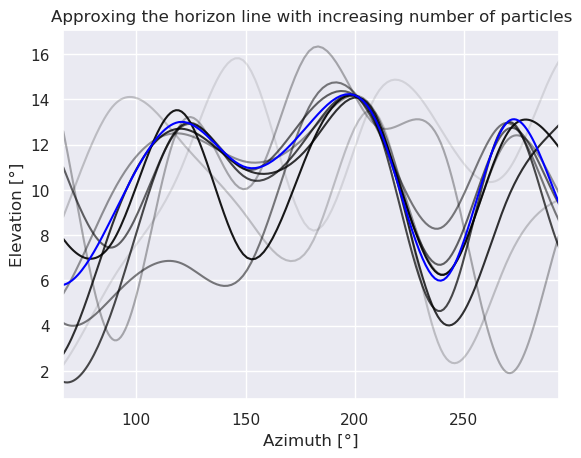

In [25]:
for ix in range(len(pso_results)):
    plot_horizon(arr2spl(pso_results[ix])).plot(alpha = ix/10 + .1, color="black")

plot_horizon(tck).plot(color="blue")
plt.ylabel("Elevation [°]")
plt.xlabel("Azimuth [°]")
plt.title("Approxing the horizon line with increasing number of particles")